In [1]:
# ! pip install torch_geometric

In [2]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv, dense_diff_pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import Entities, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj


from utils import *
from model import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Dataset
# dataset = Entities(root='data/Entities', name='MUTAG')
# dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)

# Train test split
train_split = 0.8
batch_size = 16
train_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size)


Class split - Training 0: 1901 1: 1568, Test 0: 500 1: 368


In [5]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in loader:
        adj = to_dense_adj(data.edge_index, data.batch)
        batched_x = pad_features(data)
        
        optimizer.zero_grad()

        out, l, e, _, _, _, _, _, _ = model(batched_x, adj)
        
        loss = criterion(out, data.y) + l + e
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in loader:
            adj = to_dense_adj(data.edge_index, data.batch)
            batched_x = pad_features(data)

            out, _, _, _, _, _, _, _, _= model(batched_x, adj, data.batch)
            
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

In [13]:
model = DiffPoolGNN(dataset.num_features, dataset.num_classes)  
# model = Mutag_GCN_DiffPool8(dataset.num_features, dataset.num_classes)  


lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1, Train Loss: 3.4256, Test Loss: 0.5823, Test Acc: 0.6774
Epoch 2, Train Loss: 3.3892, Test Loss: 0.5861, Test Acc: 0.6774
Epoch 3, Train Loss: 3.3652, Test Loss: 0.5847, Test Acc: 0.6797
Epoch 4, Train Loss: 3.3524, Test Loss: 0.5528, Test Acc: 0.7327
Epoch 5, Train Loss: 3.3352, Test Loss: 0.5989, Test Acc: 0.6797
Epoch 6, Train Loss: 3.3192, Test Loss: 0.5471, Test Acc: 0.7350
Epoch 7, Train Loss: 3.3135, Test Loss: 0.5408, Test Acc: 0.7396
Epoch 8, Train Loss: 3.2972, Test Loss: 0.5224, Test Acc: 0.7523
Epoch 9, Train Loss: 3.2845, Test Loss: 0.5734, Test Acc: 0.7120
Epoch 10, Train Loss: 3.2790, Test Loss: 0.5147, Test Acc: 0.7638
Epoch 11, Train Loss: 3.2763, Test Loss: 0.5384, Test Acc: 0.7627
Epoch 12, Train Loss: 3.2643, Test Loss: 0.5349, Test Acc: 0.7546
Epoch 13, Train Loss: 3.2609, Test Loss: 0.5296, Test Acc: 0.7581
Epoch 14, Train Loss: 3.2644, Test Loss: 0.5214, Test Acc: 0.7673
Epoch 15, Train Loss: 3.2528, Test Loss: 0.5246, Test Acc: 0.7615
Epoch 16, Train Los

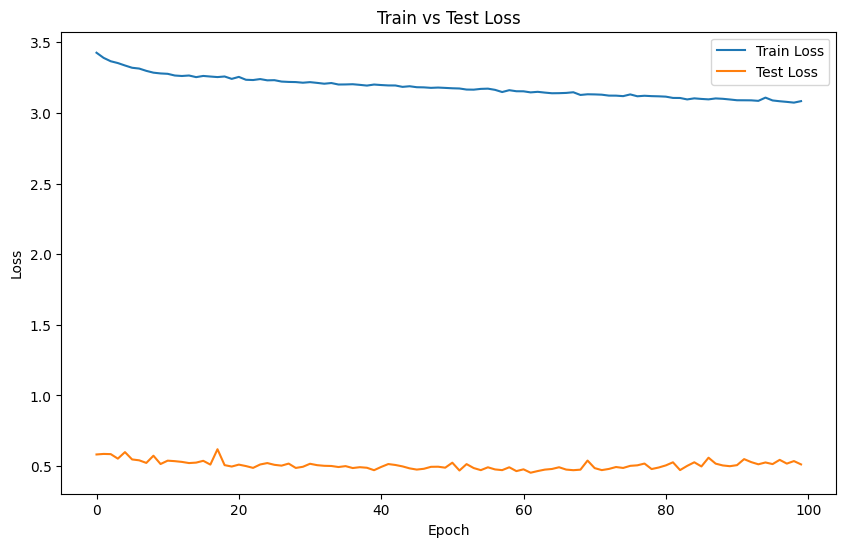

In [14]:
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

In [15]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [16]:
model0 = DiffPoolGNN(dataset.num_features, dataset.num_classes)    # Initialize model
model0.load_state_dict(torch.load('model_state_dict.pth'))
model0.eval()  # Set the model to inference mode


DiffPoolGNN(
  (conv1): DenseGCNConv(14, 32)
  (conv2): DenseGCNConv(32, 32)
  (conv3): DenseGCNConv(32, 32)
  (conv4): DenseGCNConv(32, 32)
  (conv5): DenseGCNConv(32, 32)
  (conv6): DenseGCNConv(32, 32)
  (pool1): DiffPool(
    (s): Linear(in_features=32, out_features=8, bias=True)
  )
  (pool2): DiffPool(
    (s): Linear(in_features=32, out_features=2, bias=True)
  )
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def real_graph_node(visual_data_batch):
    graph_nodes = []
    batch_size = len(visual_data_batch)
    for i in range(batch_size):
        graph_nodes.append(visual_data_batch[i].num_nodes)
    return graph_nodes


def diffpool_plot(adj, activation_space_before, activation_space_after, cluster_assignments, graph_nodes, first_diffpool, DR_method):
    """
    Input:
        adj: used for graph visualization
        activation_space_before: B * N * num_hidden_units
        activation_apace_after: B * num_cluster * num_hidden_units
        cluster_assignments: B * N
        graph_nodes: len() = B, containing the real number of nodes in each graph
        first_diffpool: only used for the first diffpool
        DR_method: 'PCA' or 'TSNE' or 'UMAP'
    Output:
        figure1: visualisation of activation_space_before
        figure2: visualisation of activation_space_after
    Note:
        Nodes in activation_space_before are colored the same color as node in activation_space_after if clustered to be the new node
    """
    batch_size, num_nodes, num_hidden_units = activation_space_before.shape
    _, num_clusters, _ = activation_space_after.shape


    # Deal with raw activation space before DiffPool
    if first_diffpool:
        relevant_features = []
        relevant_clusters = []
        for idx, real_node_number in enumerate(graph_nodes):
            # Extract the features for the relevant nodes in the graph
            relevant_features.append(activation_space_before[idx, :real_node_number, :])
            # Extract the cluster idx for the relevant nodes in the graph
            relevant_clusters.append(cluster_assignments[idx, :real_node_number])
        # Concatenate all the relevant features along the first dimension
        features1 = torch.cat(relevant_features, dim=0)
        clusters1 = torch.cat(relevant_clusters)
    else:
        features1 = activation_space_before.view(batch_size * num_nodes, num_hidden_units)
        clusters1 = cluster_assignments.view(batch_size * num_nodes)


    # Convert to numpy for dimensionality reduction
    features_np1 = features1.detach().cpu().numpy()
    # Convert cluster_numbers to numpy if it's a Tensor
    if isinstance(clusters1, torch.Tensor):
        clusters1 = clusters1.detach().cpu().numpy()

    
    # Deal with raw activation space after DiffPool
    features2 = activation_space_after.view(batch_size * num_clusters, num_hidden_units)
    features_np2 = features2.detach().cpu().numpy()
    clusters2 = np.array([i % num_clusters for i in range(batch_size * num_clusters)])
    

    # Apply Dimension Reduction 
    if DR_method == 'PCA':
        pca1 = PCA(n_components=2)
        results1 = pca1.fit_transform(features_np1)
        pca2 = PCA(n_components=2)
        results2 = pca2.fit_transform(features_np2)
    elif DR_method == 'TSNE':
        tsne1 = TSNE(n_components=2)
        results1 = tsne1.fit_transform(features_np1)
        tsne2 = TSNE(n_components=2)
        results2 = tsne2.fit_transform(features_np2)
    elif DR_method == 'UMAP':
        reducer1 = umap.UMAP(n_components=2)
        results1 = reducer1.fit_transform(features_np1)
        reducer2 = umap.UMAP(n_components=2)
        results2 = reducer2.fit_transform(features_np2)


    # ========================== Plotting Activation Space ==========================

    # Generate a colormap with distinct colors
    colors = plt.cm.jet(np.linspace(0, 1, num_clusters))

    # Activation Space before DiffPool
    plt.figure(figsize=(8, 6))
    for i, cluster in enumerate(range(num_clusters)):
        idx = clusters1 == cluster
        plt.scatter(results1[idx, 0], results1[idx, 1], color=colors[i], label=f'Cluster {cluster}')
    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space (before DiffPool)')
    plt.legend()
    plt.show()

    # Activation Space after DiffPool
    plt.figure(figsize=(8, 6))
    for i, cluster in enumerate(range(num_clusters)):
        idx = clusters2 == cluster
        plt.scatter(results2[idx, 0], results2[idx, 1], color=colors[i], label=f'Cluster {cluster}')
    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space (after DiffPool)')
    plt.legend()
    plt.show()

    # ========================== Visualizing 5 Random Graphs ==========================
    if first_diffpool:

        for i in range(5):
            n = graph_nodes[i]
            adj_single = adj[i][:n, :n]
            
            # Create a graph
            G = nx.Graph()
            for i in range(n):
                for j in range(n):
                    if adj_single[i][j] == 1:
                        G.add_edge(i, j)
            
            node_color = []
            for j in range(n):
                node_color.append(colors[clusters1[j]])
            clusters1 = clusters1[n:]

            # Draw the graph
            pos = nx.spring_layout(G)  # positions for all nodes
            nx.draw(G, pos, node_color=node_color, with_labels=True, edge_color='gray')

            plt.show()


    return


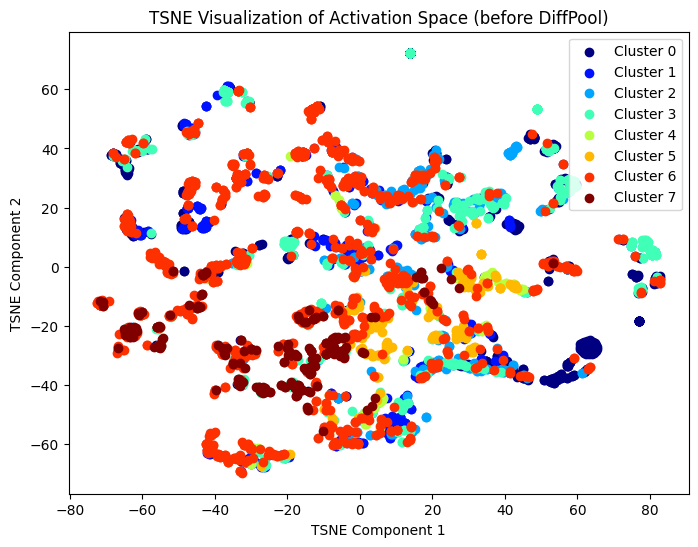

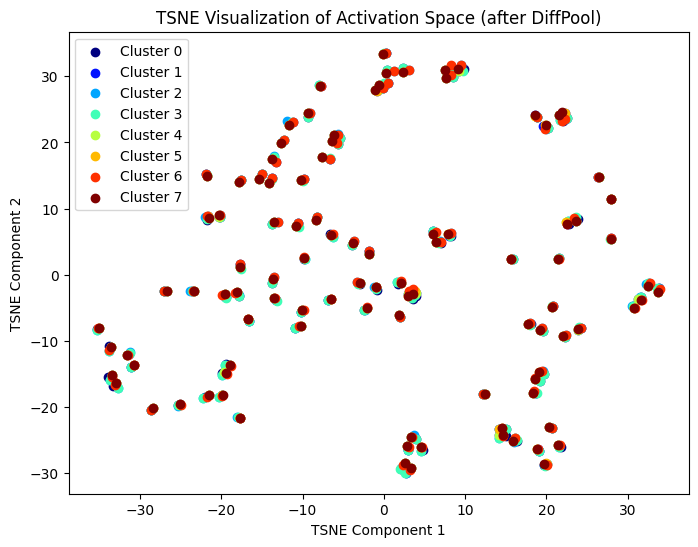

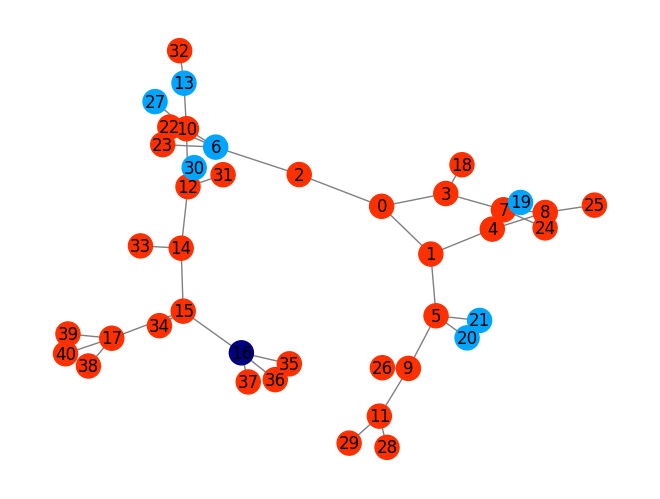

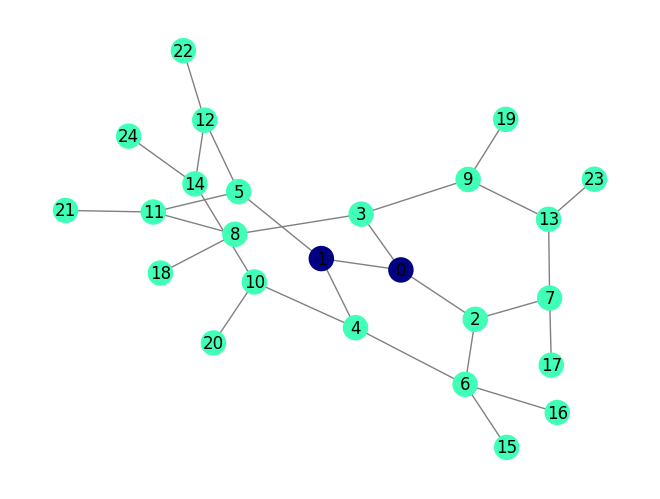

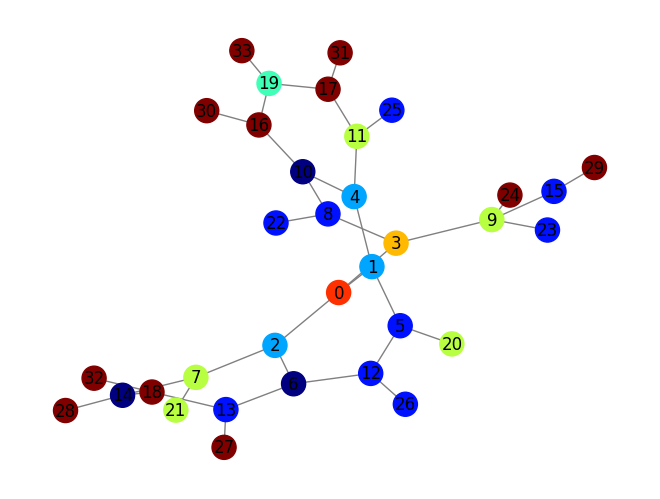

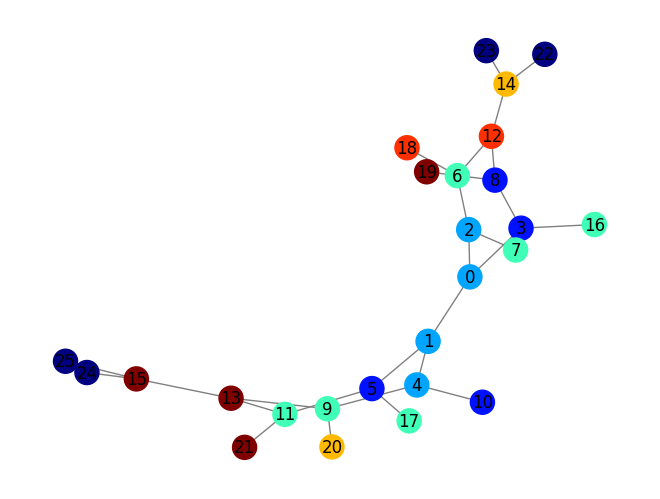

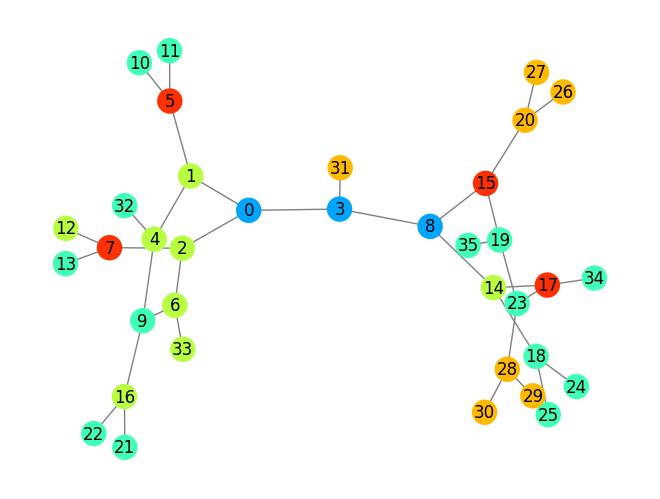

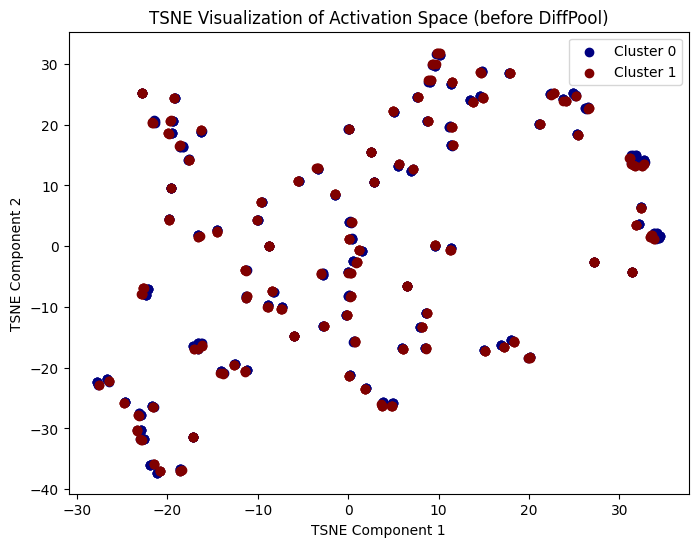

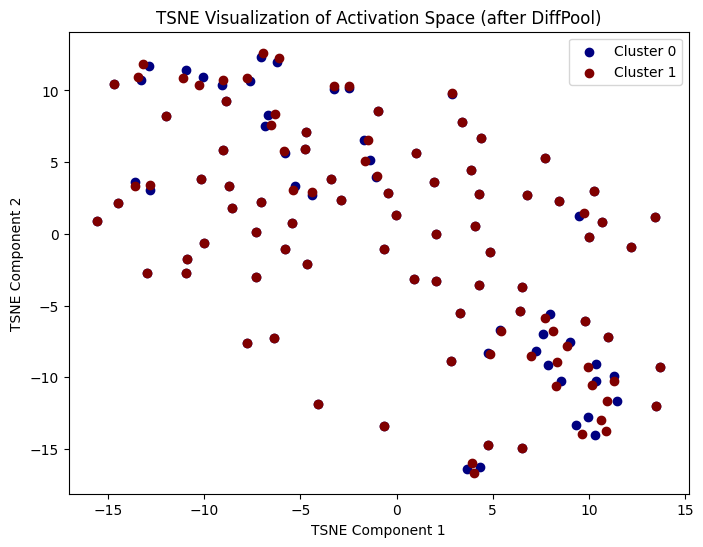

In [45]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)
    
    graph_nodes = real_graph_node(data)
    
    out, _, _, out1, cluster_assignments1, out2, cluster_assignments2, out1before, out2before = model0(batched_x, adj, data.batch)

    break


diffpool_plot(adj, out1before, out1, cluster_assignments1, graph_nodes, True, 'TSNE')
diffpool_plot(adj, out2before, out2, cluster_assignments2, graph_nodes, False, 'TSNE')

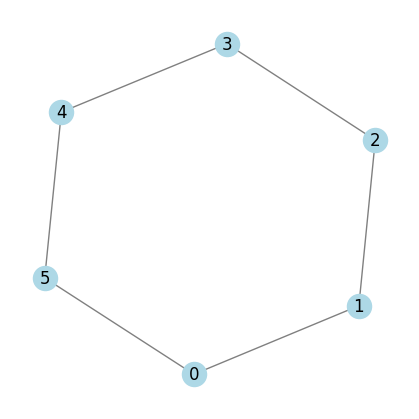

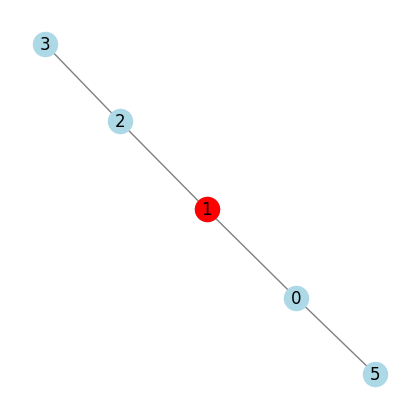

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def two_hop_neighbor(adj_matrix, target_node):
    """
    Input:
        adj_matrix
        target_node: target node idx for which we want to find the 2-hop neighborhood
    """
    # Create a graph
    G = nx.Graph()

    # Add edges based on the adjacency matrix
    n = len(adj_matrix)
    for i in range(n):
        for j in range(n):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

    
    # Find the 1-hop neighbors
    one_hop_neighbors = set(nx.neighbors(G, target_node))

    # Find the 2-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors |= set(nx.neighbors(G, neighbor))

    # Combine 1-hop and 2-hop neighbors, and include the target node itself
    neighborhood = one_hop_neighbors | two_hop_neighbors | {target_node}

    # Create the subgraph
    subgraph = G.subgraph(neighborhood)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # positions for all nodes
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

    # Highlight the target node
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[target_node], node_color='red')

    plt.show()


# Example Adjacency Matrix
adj_matrix = np.array([[0, 1, 0, 0, 0, 1],[1, 0, 1, 0, 0, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 0, 0, 1, 0, 1], [1, 0, 0, 0, 1, 0]])
two_hop_neighbor(adj_matrix, 1)


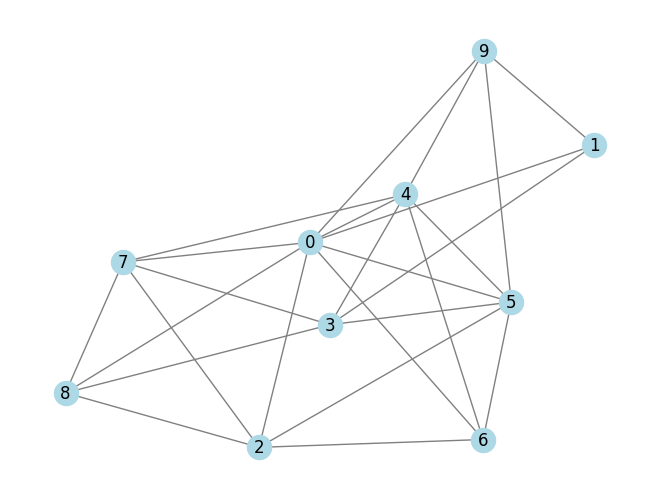

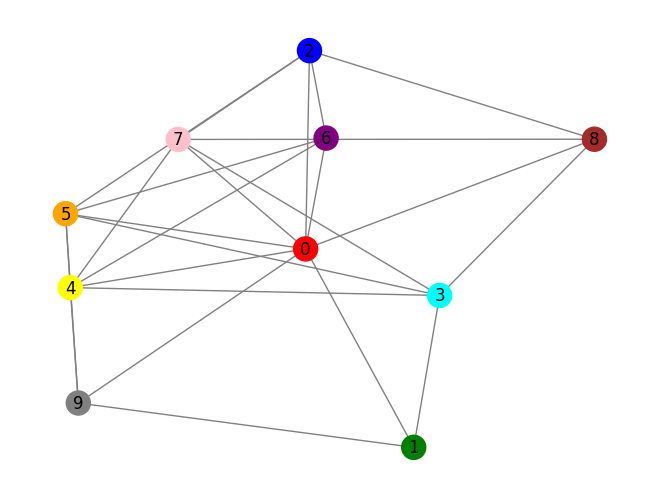

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Using the previously generated adjacency matrix
adj_matrix = np.array([
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
    [1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
])

# Create a graph
G = nx.Graph()

# Add edges based on the adjacency matrix
n = len(adj_matrix)
for i in range(n):
    for j in range(n):
        if adj_matrix[i][j] == 1:
            G.add_edge(i, j)

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

# Define colors for each node
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan']

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, node_color=colors, with_labels=True, edge_color='gray')

plt.show()
